# Deliverable 1
## TODO: idk where to use or where to put this sections of code

## Part 1

In [133]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/just_riccio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/just_riccio/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [134]:
def preprocess_text(text):
    """
    Preprocess a text by tokenizing, lowercasing, removing stop words, and stemming.
    TODO: add bonus points preprocessing (spelling correction, normalizing numbers, 
    synonym replacement / word normalization, etc.)
    """
    
    # Tokenize the text into words
    tokens = nltk.word_tokenize(text)

    # Convert to lowercase
    tokens = [token.lower() for token in tokens]

    # Remove punctuation
    tokens = [re.sub(r"[^\w\s]", "", token) for token in tokens]
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove punctuation
    tokens = [re.sub(r"[^\w\s]", "", token) for token in tokens]

    # Stem the tokens
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # Remove empty strings
    tokens = [token for token in tokens if token]

    return tokens

def clean_seller(text):
    # Remove unwanted trailing phrases and everything after them
    remove_phrases = [
        "Seller changed",
        "(Not Enough Ratin",
        "(New Sell"
    ]
    for phrase in remove_phrases:
        idx = text.find(phrase)
        if idx != -1:
            text = text[:idx]
    return text.strip()

def preprocess_non_textual(document):
    # TODO: preprocess non-textual parts of the document (e.g., numerical data normalization)
    # based on the remaining part of this notebook (section 3 and 4)

    # Discount preprocessing: convert from string "xx% off" to integer xx
    # also taking into account documents without discount
    if isinstance(document["discount"], str) and "%" in document["discount"]:
        document["discount"] = int(document["discount"][:document["discount"].find("%")])
    else:
        document["discount"] = 0
        
    # Merge all values from product_details dictionary and preprocess
    if isinstance(document["product_details"], dict):
        details_text = " ".join(str(v) for v in document["product_details"].values())
    elif isinstance(document["product_details"], list):
        # If it's a list of dicts, merge all values from all dicts
        details_text = " ".join(str(v) for d in document["product_details"] if isinstance(d, dict) for v in d.values())
    else:
        details_text = str(document["product_details"])
    document["product_details"] = preprocess_text(details_text)

    # Convert actual_price and selling_price to integers (remove commas)
    # If actual_price is nan, set it to discounted selling_price
    for price_field in ["actual_price", "selling_price"]:
        if isinstance(document[price_field], str):
            price_str = document[price_field].replace(",", "")
            price_val = price_str.split(".")[0]
            document[price_field] = int(price_val) if price_val.isdigit() else 0

    # If actual_price is missing or zero, set it to discounted selling_price
    if ("actual_price" not in document or document["actual_price"] == 0) and "selling_price" in document:
        document["actual_price"] = int(int(document["selling_price"])*document["discount"]/100)

    # Convert average_rating to float, set to NaN if missing or empty
    if "average_rating" in document and str(document["average_rating"]).strip() != "":
        try:
            document["average_rating"] = float(document["average_rating"])
        except ValueError:
            document["average_rating"] = float("nan")
    else:
        document["average_rating"] = float("nan")

    return document

def preprocess_document(document):
    """
    For each textual part of the document, preprocess it
    """

    document["description"] = preprocess_text(document["description"])
    document["title"] = preprocess_text(document["title"])
    document["seller"] = clean_seller(document["seller"])

    document = preprocess_non_textual(document)

    return document


## Section 3
Pros of keeping separate: end user can easily filter products (i.e. if category / sub-category / brand fully matches user filter, product is relevant, otherwise it's not)

Cons of keeping separate: more computation to check general relevance of products

Pros of merging: every aspect of the product helps with relevance (e.g. user can query (not filter) for brands, and the most relevant products will be the one with the user requested brands, but other products, which might still be useful for the user, could still be relevant)

Cons of merging: you lose the option to filter


Maybe some fields could be saved in the inverted index tree using one-hot encoding, to try a hybrid approach, depending on how one wants to build its retrieval engine


Also, after doing some EDA, we have seen that there are not that many categories, sub-categories and brand, thus merging everything together would not even make that much impact on the relevance of the products, as many products share those same values, making their inverse-document-frequency not significant in the retrieval.

As product details is an array of various, non homogeneous entries, we assumed it would have been best to simply merge all of the entries as similar products might have similar entries and values

## Section 4
out_of_stock: boolean -> if it is out of stock, do not consider this product
selling_price: numerical -> used to filer
discount: numerical -> used to calculate new selling price then filter (could be split into two fields: is_discounted (boolean), discount_value (numerical))
actual_price: numerical -> idk what this is
average_rating: numerical -> filter

## Part 2

In [135]:
# Exploratory Data Analysis

file_path = "data/fashion_products_dataset.json"  # TODO: fix path to use env variables

# Open and load JSON file
with open(file_path, "r") as f:
    data = json.load(f)
    df = pd.DataFrame(data)

print(df.head())


                                    _id actual_price average_rating brand  \
0  fa8e22d6-c0b6-5229-bb9e-ad52eda39a0a        2,999            3.9  York   
1  893e6980-f2a0-531f-b056-34dd63fe912c        1,499            3.9  York   
2  eb4c8eab-8206-59d0-bcd1-a724d96bf74f        2,999            3.9  York   
3  3f3f97bb-5faf-57df-a9ff-1af24e2b1045        2,999            3.9  York   
4  750caa3d-6264-53ca-8ce1-94118a1d8951        2,999            3.9  York   

                   category     crawled_at  \
0  Clothing and Accessories  1612987911000   
1  Clothing and Accessories  1612987912000   
2  Clothing and Accessories  1612987912000   
3  Clothing and Accessories  1612987913000   
4  Clothing and Accessories  1612987913000   

                                         description discount  \
0  Yorker trackpants made from 100% rich combed c...  69% off   
1  Yorker trackpants made from 100% rich combed c...  66% off   
2  Yorker trackpants made from 100% rich combed c...  68% off   


In [136]:
# Basic Data Exploratory Analysis

# 1. Overview of missing values (NaN and empty strings)
missing_info = df.isnull().sum()
empty_info = (df == '').sum()
print("\nEmpty string values per column:\n", empty_info)

# 2. Number of unique brands, categories, sub-categories (excluding empty strings)
print("\nUnique brands (excluding empty):", df.loc[df['brand'] != '', 'brand'].nunique())
print("Unique categories (excluding empty):", df.loc[df['category'] != '', 'category'].nunique())
print("Unique sub-categories (excluding empty):", df.loc[df['sub_category'] != '', 'sub_category'].nunique())

# 3. Top 10 brands by product count (excluding empty)
print("\nTop 10 brands by product count:\n", df.loc[df['brand'] != '', 'brand'].value_counts().head(10))

# 4. Distribution of products by category (excluding empty)
print("\nProduct count by category:\n", df.loc[df['category'] != '', 'category'].value_counts())

# 5. Distribution of products by sub-category (top 10, excluding empty)
print("\nTop 10 sub-categories by product count:\n", df.loc[df['sub_category'] != '', 'sub_category'].value_counts().head(10))

# 6. Out of stock ratio
out_of_stock_ratio = df['out_of_stock'].mean()
print(f"\nOut of stock ratio: {out_of_stock_ratio:.2%}")

# 7. Summary statistics for prices and ratings
print("\nSummary statistics for actual_price, selling_price, discount, average_rating:")
print(df[['actual_price', 'selling_price', 'discount', 'average_rating']].describe())


Empty string values per column:
 _id                    0
actual_price         777
average_rating      2261
brand               2009
category               0
crawled_at             0
description        11150
discount             855
images                 0
out_of_stock           0
pid                    0
product_details        0
seller              1643
selling_price          2
sub_category           0
title                  0
url                    0
dtype: int64

Unique brands (excluding empty): 324
Unique categories (excluding empty): 4
Unique sub-categories (excluding empty): 24

Top 10 brands by product count:
 brand
ECKO Unl        951
Free Authori    860
ARBO            806
REEB            802
Pu              798
True Bl         793
Keo             660
Amp             585
Black Beat      548
vims rai        503
Name: count, dtype: int64

Product count by category:
 category
Clothing and Accessories    27118
Footwear                      920
Bags, Wallets & Belts          41
T

In [137]:
# Find products with empty selling_price, actual_price, or discount
empty_prices = df[(df['selling_price'] == '') | (df['actual_price'] == '') | (df['discount'] == '')]

# Print the number of such products
print(f"Number of products with empty selling_price, actual_price, or discount: {len(empty_prices)}")

# Show a few examples
print(empty_prices[['title', 'brand', 'selling_price', 'actual_price', 'discount']].sample(10))

Number of products with empty selling_price, actual_price, or discount: 855
                                              title             brand  \
7678                     Solid Men Blue Track Pants                     
15983  Graphic Print Women Round Neck Black T-Shirt  HUMANITY ORIGINA   
3981           Full Sleeve Solid Men Leather Jacket              Cher   
3786   Lethal Football Shoes For Men  (White, Blue)            Vector   
3048             Full Sleeve Solid Women Sweatshirt              AXMA   
8577                                     Men Trunks                 V   
14347                           Slim Men Blue Jeans               Lev   
3092     AXMANN Round Neck Self Design Men Pullover                     
8468                       Women Brief  (Pack of 4)                 V   
25617           Color Block Women Black Track Pants                Pu   

      selling_price actual_price discount  
7678            995                        
15983           699             

In [138]:
def impute_actual_price(row):
    # if actual_price is empty, try to compute it:
    # either from selling_price and discount, or just use selling_price
    if row['actual_price'] == '':
        # Convert selling_price and discount to float if not empty
        if row['selling_price'] != '' and row['discount'] != '':
            selling_price = float(str(row['selling_price']).replace(',', ''))
            discount = float(str(row['discount']).replace('%', '').replace('off', '').strip())
            return selling_price * (1 - discount / 100)
        elif row['selling_price'] != '':
            return float(str(row['selling_price']).replace(',', ''))
    return row['actual_price']

df['actual_price'] = df.apply(impute_actual_price, axis=1)
df['discount'] = df['discount'].replace('', '0')
# Check for empty strings in each column
empty_info = (df == '').sum()
print("Empty string values per column:\n", empty_info)

Empty string values per column:
 _id                    0
actual_price           2
average_rating      2261
brand               2009
category               0
crawled_at             0
description        11150
discount               0
images                 0
out_of_stock           0
pid                    0
product_details        0
seller              1643
selling_price          2
sub_category           0
title                  0
url                    0
dtype: int64


In [139]:
df = df[(df['actual_price'] != '') & (df['selling_price'] != '')]
print("Empty string values per column:\n", (df == '').sum())

Empty string values per column:
 _id                    0
actual_price           0
average_rating      2259
brand               2009
category               0
crawled_at             0
description        11149
discount               0
images                 0
out_of_stock           0
pid                    0
product_details        0
seller              1641
selling_price          0
sub_category           0
title                  0
url                    0
dtype: int64


In [140]:
df.loc[df['brand'] == '', 'brand'] = 'no brand'

We have done some data cleaning, there are still some products that do not have average rating. For the moment we are just keeping those values, we will decide later what to do with this values. Besides, we could drop crawled_at and images, but for now we keep them.

In [ ]:
# Print 5 random entries from the dataset
df = df.apply(preprocess_document, axis=1)
print(df.sample(5))

                                        _id  actual_price  average_rating  \
25218  bd2e1f73-845f-5ba3-bc6e-f2c0b60333e7         699.0             3.9   
12448  9f439c2b-8b0a-5a8b-aa91-7298bcd6dc10        1499.0             3.4   
15898  1ddd46f7-d7ce-5f92-acd1-20af2ffd97a8         699.0             NaN   
14519  bf7afaa7-695e-569f-bc07-d5588dded145         699.0             3.9   
12824  b4e595db-d17c-5730-a466-6b65f29fae60        1899.0             3.4   

                  brand                  category     crawled_at  \
25218            TOM BU  Clothing and Accessories  1613005324000   
12448               Amp  Clothing and Accessories  1612996803000   
15898  HUMANITY ORIGINA  Clothing and Accessories  1612999168000   
14519    ECOLINE Clothi  Clothing and Accessories  1612998369000   
12824               Amp  Clothing and Accessories  1612997068000   

                                             description  discount  \
25218  [cotton, collar, tshirt, manufactur, ultra, so...  

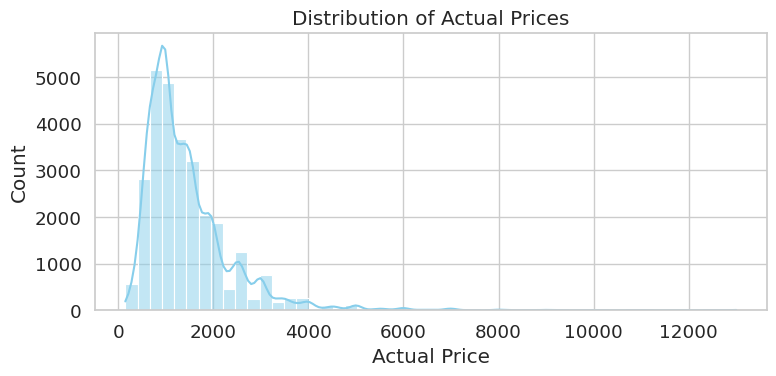

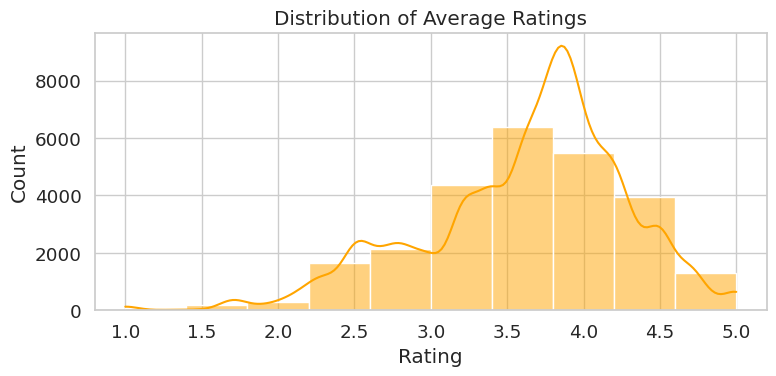

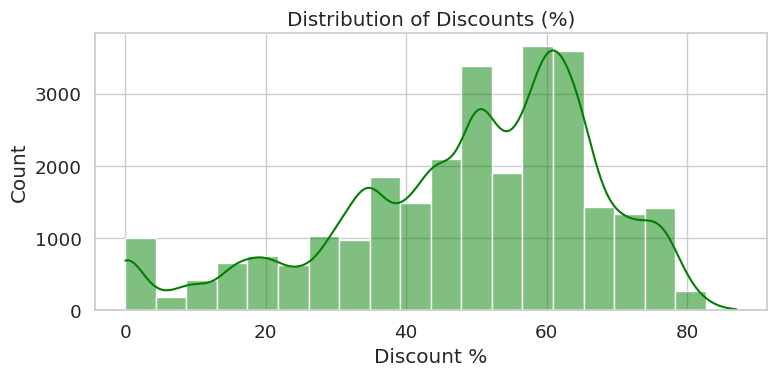

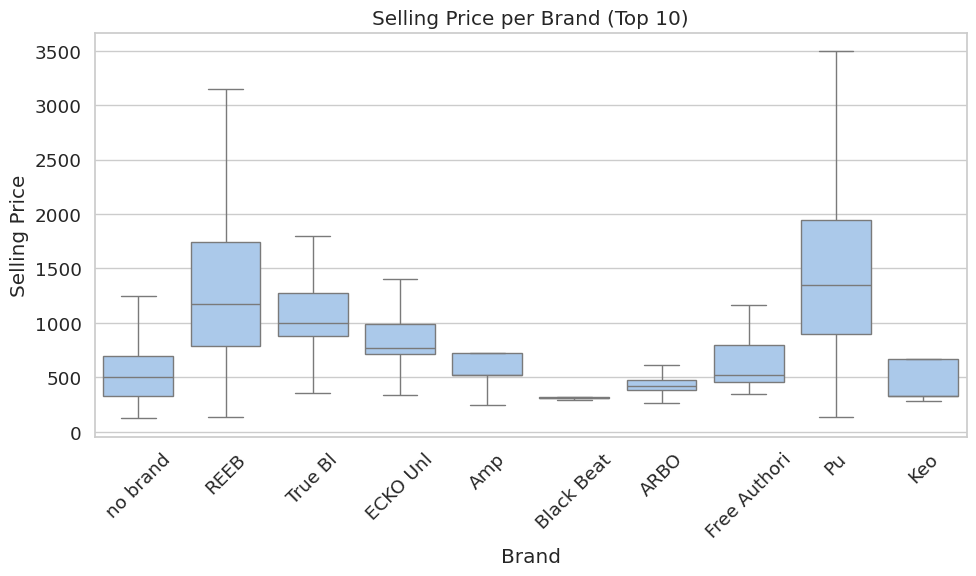

In [142]:
# Set a nicer style
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)

# Actual Price Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df["actual_price"], bins=50, kde=True, color="skyblue")
plt.title("Distribution of Actual Prices")
plt.xlabel("Actual Price")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Ratings Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df["average_rating"], bins=10, kde=True, color="orange")
plt.title("Distribution of Average Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Discounts Distribution
plt.figure(figsize=(8, 4))
sns.histplot(df["discount"], bins=20, kde=True, color="green")
plt.title("Distribution of Discounts (%)")
plt.xlabel("Discount %")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Selling price per brand (top 10 brands)
top_brands = df["brand"].value_counts().head(10).index
plt.figure(figsize=(10, 6))
sns.boxplot(x="brand", y="selling_price", data=df[df["brand"].isin(top_brands)], showfliers=False)
plt.title("Selling Price per Brand (Top 10)")
plt.xlabel("Brand")
plt.ylabel("Selling Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Total words: 521327
Vocabulary size: 5568
Average sentence length: 18.567098796210555

Top 5 products by rating:
                                                   title  average_rating
22361                              [men, brief, pack, 5]             5.0
8403                         [vip, women, vest, pack, 8]             5.0
14764  [graphic, print, women, round, neck, white, ts...             5.0
13240                              [men, brief, pack, 5]             5.0
10472  [men, slim, fit, print, spread, collar, casual...             5.0

Top 5 cheapest products:
                                              title  selling_price
16485                 [women, midcalfcrew, pack, 2]             99
20435                         [men, print, bandana]             99
7654   [women, color, block, ankl, length, pack, 3]            118
24438           [men, solid, ankl, length, pack, 3]            120
24437         [women, solid, ankl, length, pack, 3]            120

Top 5 products by di

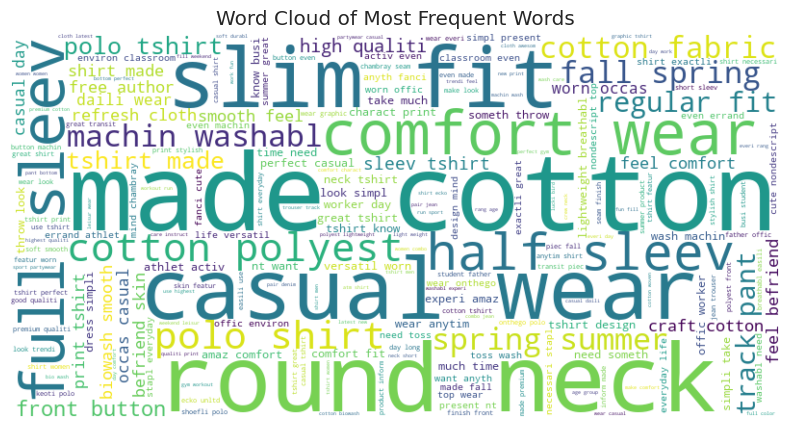

In [143]:
# 1. Word counting, average sentence length, vocabulary size
all_text = " ".join(df["description"].astype(str).tolist())
# Use a simple regex-based tokenizer instead of nltk.word_tokenize
words = re.findall(r'\b\w+\b', all_text.lower())
vocab = set(words)
print("Total words:", len(words))
print("Vocabulary size:", len(vocab))
print("Average sentence length:", np.mean([len(re.findall(r'\b\w+\b', s.lower())) for s in df["description"].astype(str).tolist()]))

# 2. Ranking of products based on rating, price, discount
print("\nTop 5 products by rating:")
print(df.sort_values("average_rating", ascending=False)[["title", "average_rating"]].head())

print("\nTop 5 cheapest products:")
print(df.sort_values("selling_price")[["title", "selling_price"]].head())

print("\nTop 5 products by discount:")
print(df.sort_values("discount", ascending=False)[["title", "discount"]].head())

# 3. Top sellers and brands
print("\nTop 5 sellers:")
print(df["seller"].value_counts().head())

print("\nTop 5 brands:")
print(df["brand"].value_counts().head())

# 4. Word cloud for most frequent words
filtered_words = [w.lower() for w in words if w.isalpha() and w.lower() not in stopwords.words('english')]
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(filtered_words))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Frequent Words")
plt.show()
